In [24]:
# 2017-02-01

In [5]:
# 1.1 Import tensorflow and other libraries.

import tensorflow as tf
import numpy as np
%matplotlib inline
import pylab

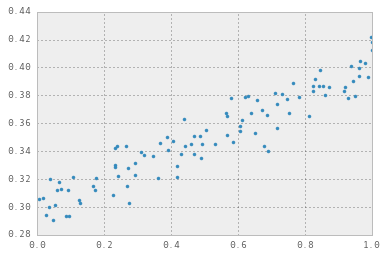

In [6]:
# 1.2 Create input data using NumPy. y = x * 0.1 + 0.3 + noise
x_data = np.random.rand(100).astype(np.float32)
noise = np.random.normal(scale=0.01, size=len(x_data))
y_data = x_data * 0.1 + 0.3 + noise

# Uncomment the following line to plot our input data.
pylab.plot(x_data, y_data, '.')


In [11]:
# 1.3 Buld inference graph.
W = tf.Variable(tf.random_uniform([1], 0.0, 1.0))
b = tf.Variable(tf.zeros([1]))
y = W * x_data + b

In [14]:
# 1.4 Build training graph.
loss = tf.reduce_mean(tf.square(y - y_data))
optimizer = tf.train.GradientDescentOptimizer(.5)
train = optimizer.minimize(loss)
init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [18]:
# 1.6 Create a session and launch the graph.
sess = tf.Session()
sess.run(init)
y_initial_values = sess.run(y)

In [21]:
# 1.7 Perform training.
for step in xrange(201):
    sess.run(train)

print(sess.run([W, b]))

[array([ 0.1015112], dtype=float32), array([ 0.29940289], dtype=float32)]


(0, 1.0)

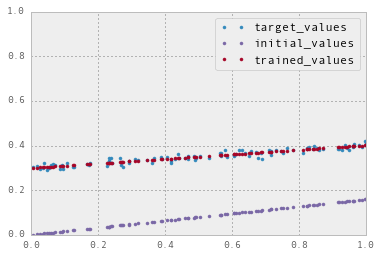

In [23]:
# 1.8 Uncomment the following lines to compare.
pylab.plot(x_data, y_data, '.', label="target_values")
pylab.plot(x_data, y_initial_values, ".", label="initial_values")
pylab.plot(x_data, sess.run(y), ".", label="trained_values")
pylab.legend()
pylab.ylim(0, 1.0)


In [1]:
# 2017-02-02

In [2]:
import math
import os
from six.moves import xrange
import numpy as np
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets

%matplotlib inline
import matplotlib.pyplot as plt

/Users/masato/duolingo/env/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
NUM_CLASSES = 10
IMAGE_SIZE = 28
IMAGE_PIXELS = IMAGE_SIZE * IMAGE_SIZE

BATCH_SIZE = 100
EVAL_BATCH_SIZE = 1

HIDDEN1_UNITS = 128
HIDDEN2_UNITS = 32

MAX_STEPS = 2000

TRAIN_DIR = '/Users/masato/dev/mnist'

In [6]:
data_sets = read_data_sets(TRAIN_DIR, False)

Extracting /Users/masato/dev/mnist/train-images-idx3-ubyte.gz
Extracting /Users/masato/dev/mnist/train-labels-idx1-ubyte.gz
Extracting /Users/masato/dev/mnist/t10k-images-idx3-ubyte.gz
Extracting /Users/masato/dev/mnist/t10k-labels-idx1-ubyte.gz


In [7]:
data_sets

Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x11200c2d0>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x11200c290>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x1128da550>)

In [9]:
def mnist_inference(images, hidden1_untis, hidden2_units):
    with tf.name_scope('hidden1'):
        weights = tf.Variable(
            tf.truncated_normal([IMAGE_PIXELS, hidden1_untis],
                                stddev = 1.0 / math.sqrt(float(IMAGE_PIXELS))),
            name='weights')
        
        biases = tf.Variable(tf.zeros([hidden1_units]),
                             name='biases')
        hidden1 = tf.nn.relu(tf.matmu(images, weights) + biases)
        
    with tf.name_scope('hidden2'):
        weights = tf.Variable(
            tf.truncated_normal([hidden1_units, hidden2_units],
                                stddev = 1.0 / math.sqrt(float(hidden1_units))),
            name='weights')
        biases = tf.Variable(tf.zeros([hidden2_units]),
                             name='biases')
        hidden2 = tf.nn.relu(tf.matmu(hidden1, weights) + biases)
        
    with tf.name_scope('softmax_linear'):
        weights = tf.Variable(
            tf.truncated_normal([hidden2_units, NUM_CLASSES],
                                stddev = 1.0 / math.sqrt(float(hidden2_units))),
            name='weights')
        biases = tf.Variable(tf.zeros([NUM_CLASSES]),
                             name='biases')
        logits = tf.matmu(hidden2, weights) + biases
    
    return logits